### **"Love is the star to every wandering bark." - Will Shakespeare**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics.pairwise import cosine_similarity

from gensim import corpora, models, similarities, matutils
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel

from textblob import TextBlob
from wordcloud import WordCloud
import pickle

In [2]:
with open('all_acts_1.pkl', 'rb') as f:
    all_acts = pickle.load(f)

In [3]:
Shakespearean_stop_words = [
     'thou', 'thy', 'shall', 'thee', 'come', 'enter', 'thine', 'art', 
     'ay', 'would', 'alas', 'dost', 'doth', 'ere', 'hast', 'tis', 'twas', 
     'wast', 'whence', 'wherefore', 'oft', 'yea', 'aught', 'yon', 'yonder', 
     'nay', 'hie', 'hither', 'good', 'haue', 'hath', 'lord', 'let', 'like', 'nurse',
     'make', 'say', 'sir', 'lear', 'macb', 'theseus', 'banquo', 'rosalind', 'orlando', 
     'demetrius', 'celia', 'hamlet', 'jaques','anthonio', 'palamon', 'arcite', 'emilia', 
     'oliver', 'ariel', 'phebe', 'audrey', 'silvius', 'theobald', 'steevens', 
     'doe', 'loue', 'did', 'man', 'rowe', 'capell', 'shy', 'ham', 'th', 'know', 
     'ile', 'vs', 'ile', 'heere', 'giue', 'edg', 'ff', 'Enter', 'Serv.', 'Exeunt',
     'PROLOGUE', 'tis', 'kent', 'edmund', 'vpon', 'oh', 'vp', 'ye', 'yes', 'perithous',
     'bassanio', 'gloucester', 'edm', 'reg', 'gon', 'rom', 'jul', 'cap', 'ore', 'glou',
     'gent'
]

union_stop_words = text.ENGLISH_STOP_WORDS.union(Shakespearean_stop_words)


all_acts_text_list = []
for i in range(len(all_acts)):
    all_acts_text_list.append(all_acts[:][i]['Text'])


In [4]:
len(Shakespearean_stop_words)

100

# Vectorizing Words

In [5]:
count_vectorizer = CountVectorizer(stop_words=union_stop_words, token_pattern="\\b[a-z][a-z]+\\b", min_df=0.1, max_df=0.9, ngram_range=(1,2))
count_vectorizer.fit(all_acts_text_list)
doc_word = count_vectorizer.transform(all_acts_text_list)
doc_word.shape

# tfidf_vectorizer = TfidfVectorizer(stop_words=union_stop_words, 
#                                    token_pattern="\\b[a-z][a-z]+\\b", 
#                                    min_df=0.1, 
#                                    max_df=0.9, 
#                                    ngram_range=(1,2))

# tfidf_vectorizer.fit(all_acts_text_list)
# doc_word = tfidf_vectorizer.transform(all_acts_text_list)
# doc_word.shape

/Users/joelporcaro/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['exeunt', 'prologue', 'serv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(42, 2419)

In [6]:
# doc_word = tfidf_vectorizer.transform(all_acts_text_list).transpose()

In [7]:
corpus = matutils.Sparse2Corpus(doc_word)
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())
id2word = dict((v, k) for k, v in tfidf_vectorizer.vocabulary_.items())
# len(id2word)

NameError: name 'tfidf_vectorizer' is not defined

# Modeling

## LDA - Latent Dirichlet Allocation

In [8]:
lda = models.LdaModel(corpus=corpus, num_topics=3, id2word=id2word, passes=10)

In [9]:
lda.print_topics()

[(0,
  '0.214*"absolute" + 0.065*"absent" + 0.058*"acquaintance" + 0.053*"acquaint" + 0.047*"alack" + 0.043*"aged" + 0.042*"air" + 0.042*"act" + 0.042*"afraid" + 0.038*"account"'),
 (1,
  '0.117*"addition" + 0.113*"age" + 0.090*"actors" + 0.079*"afore" + 0.079*"advance" + 0.078*"againe" + 0.067*"afraid" + 0.057*"actions" + 0.054*"affliction" + 0.051*"adieu"'),
 (2,
  '0.072*"aboue" + 0.071*"abusd" + 0.067*"accent" + 0.066*"abide" + 0.060*"albany" + 0.060*"abuses" + 0.057*"alacke" + 0.057*"able" + 0.056*"abuse" + 0.045*"adventure"')]

In [10]:
doc_word.shape

(42, 2419)

## LSA - Latent Semantic Analysis

In [11]:
lsa = TruncatedSVD(4)
# doc_word = doc_word.transpose()
doc_topic = lsa.fit_transform(doc_word)
lsa.explained_variance_ratio_

array([0.16994782, 0.1738173 , 0.07080634, 0.05547588])

In [12]:
lsa.components_

array([[ 0.00353342,  0.00394113,  0.00858981, ...,  0.00468819,
         0.04696536,  0.0028253 ],
       [ 0.00278868, -0.00335254,  0.01272863, ..., -0.01029808,
         0.00115446, -0.00559834],
       [-0.00726663, -0.00699743,  0.00224983, ...,  0.00467669,
        -0.02226129, -0.00398512],
       [-0.00342742, -0.00678239,  0.003126  , ..., -0.00237764,
        -0.00406206,  0.00596629]])

In [13]:
topic_word = pd.DataFrame(lsa.components_.round(2),
                         index = ['component_1', 'component_2', 'component_3', 'component_4'],
                         columns = count_vectorizer.get_feature_names())
topic_word

,abide,able,aboue,abroad,absence,absent,absolute,abusd,abuse,abuses,...,yesterday,yield,yond,yong,youl,youll,young,younger,youth,youthful
component_1,0.00,0.00,0.01,0.01,0.0,0.0,0.0,0.01,0.0,0.00,...,0.0,0.00,0.01,0.03,0.01,0.01,0.05,0.00,0.05,0.00
component_2,0.00,-0.00,0.01,-0.00,0.0,0.0,0.0,-0.01,0.0,-0.00,...,0.0,-0.01,-0.01,0.03,0.01,-0.02,-0.06,-0.01,0.00,-0.01
component_3,-0.01,-0.01,0.00,-0.01,-0.0,-0.0,-0.0,0.01,-0.0,-0.00,...,-0.0,0.01,-0.00,-0.05,-0.02,-0.00,-0.00,0.00,-0.02,-0.00
component_4,-0.00,-0.01,0.00,0.00,-0.0,0.0,-0.0,-0.00,0.0,0.01,...,-0.0,-0.00,0.01,-0.06,-0.03,0.00,0.00,-0.00,-0.00,0.01


In [14]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
            for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [15]:
display_topics(lsa, count_vectorizer.get_feature_names(), 10)


Topic  0
king, love, father, night, ill, selfe, old, exeunt, daughter, fool

Topic  1
king, selfe, speake, queene, thinke, looke, heauen, play, heare, owne

Topic  2
fool, king, corn, father, poor, nature, france, speak, regan, goneril

Topic  3
night, dead, king, lady, ill, mother, god, wife, fair, wilt


## NMF - Non-Negative Matrix Factorization

In [16]:
doc_word.shape

(42, 2419)

In [114]:
nmf_model = NMF(5)
doc_topic = nmf_model.fit_transform(doc_word)

In [115]:
doc_word.shape

(42, 2419)

In [116]:
topic_word = pd.DataFrame(nmf_model.components_.round(2),
             index = ["component_1", "component_2", 'component_3', 'component_4', 'component_5'],
             columns = count_vectorizer.get_feature_names())
topic_word

,abide,able,aboue,abroad,absence,absent,absolute,abusd,abuse,abuses,...,yesterday,yield,yond,yong,youl,youll,young,younger,youth,youthful
component_1,0.00,0.00,0.25,0.02,0.00,0.09,0.10,0.01,0.08,0.08,...,0.08,0.00,0.03,0.52,0.20,0.00,0.34,0.00,0.75,0.00
component_2,0.00,0.05,0.00,0.13,0.00,0.02,0.00,0.03,0.04,0.08,...,0.02,0.02,0.19,0.00,0.00,0.20,0.97,0.10,0.50,0.10
component_3,0.01,0.02,0.00,0.02,0.01,0.01,0.00,0.16,0.01,0.00,...,0.01,0.11,0.10,0.00,0.00,0.11,0.65,0.12,0.17,0.02
component_4,0.00,0.09,0.00,0.08,0.00,0.02,0.04,0.00,0.03,0.00,...,0.00,0.00,0.00,0.63,0.32,0.03,0.20,0.01,0.29,0.00
component_5,0.21,0.06,0.09,0.09,0.11,0.02,0.02,0.03,0.00,0.00,...,0.04,0.00,0.07,0.58,0.09,0.00,0.09,0.00,0.29,0.01


In [117]:
display_topics(nmf_model, count_vectorizer.get_feature_names(), 15)


Topic  0
king, selfe, play, queene, mother, father, heauen, thinke, speake, looke, owne, soule, dead, heare, downe

Topic  1
love, ill, night, lady, fair, wife, dead, god, look, speak, wilt, old, word, gone, dear

Topic  2
fool, father, ill, king, old, speak, corn, poor, duke, love, nature, daughter, son, france, better

Topic  3
daughter, love, cosen, friend, faire, doctor, goe, noble, em, duke, thinke, woman, againe, oth, honour

Topic  4
goe, neuer, iew, night, speake, faire, selfe, looke, leaue, lysander, hermia, feare, heare, father, moone


In [154]:
H = pd.DataFrame(doc_topic.round(5),
             columns = ["component_1", "component_2", 'component_3', 'component_4', 'component_5'])
H.head()

,component_1,component_2,component_3,component_4,component_5
0,0.00000,5.95888,0.00000,0.00000,0.17082
1,0.00000,6.18521,0.00000,0.11878,0.00000
2,0.24293,6.70917,0.00000,0.00000,0.02927
3,0.34937,3.19105,0.02451,0.00000,0.00000
4,0.00000,2.51845,0.31497,0.00000,0.62684


In [155]:
# sums = pd.Series(H.sum(axis=1))

# H = H.div(H.sum(axis=1), axis=0)
H

,component_1,component_2,component_3,component_4,component_5
0,0.00000,5.95888,0.00000,0.00000,0.17082
1,0.00000,6.18521,0.00000,0.11878,0.00000
2,0.24293,6.70917,0.00000,0.00000,0.02927
3,0.34937,3.19105,0.02451,0.00000,0.00000
4,0.00000,2.51845,0.31497,0.00000,0.62684
5,2.22512,0.00000,0.25629,0.00000,3.22074
6,11.56169,0.00000,0.00000,0.00000,0.00000
7,0.00000,0.00000,8.93122,0.36045,0.00000
8,0.11032,0.03530,5.85767,0.00000,0.31011
9,0.17601,0.00000,5.81249,0.00000,0.23237


In [162]:
roju_ind = [0, 1, 2, 3, 4]
hamlet_ind = [5,6]
king_lear_ind = [7, 8, 9, 10, 11]
merchantvenice_ind = [12, 13, 14, 15, 16]
midsummer_ind = [17, 18, 19, 20, 21]
tempest_ind = [22, 23, 24, 25, 26]
kinsmen_ind = [27, 28, 29, 30, 31]
macbeth_ind = [32, 33, 34, 35, 36]
asyoulikeit_ind = [37, 38, 39, 40, 41]

early_play_inds = [0, 1, 2, 3, 4, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
late_plays_inds = [5, 6, 7, 8, 9, 10, 11, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

In [171]:
early_topic_bars = H.iloc[early_play_inds].mean()
later_topic_bars = H.iloc[late_plays_inds].mean()

In [207]:
early_topic_normalized = []
for i in early_topic_bars.values:
    early_topic_normalized.append(i / np.sum(early_topic_bars.values))
early_topic_normalized

[0.06616526427560535,
 0.3494350758788223,
 0.09176636067172785,
 0.07390487714159161,
 0.41872842203225297]

In [209]:
later_topic_normalized = []
for i in later_topic_bars.values:
    later_topic_normalized.append(i / np.sum(later_topic_bars.values))
later_topic_normalized

[0.19837507111559152,
 0.08201304132889989,
 0.36472813508904955,
 0.29707989830255305,
 0.057803854163906085]

In [201]:
early_topic_bars.values

5

In [195]:
np.sum(later_topic_bars)

5.127319411764705

([0, 1, 2, 3, 4], <a list of 5 Text xticklabel objects>)

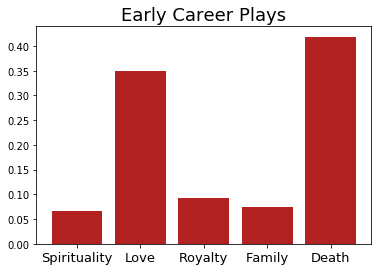

In [213]:
plt.bar(['Spirituality', 'Love', 'Royalty', 'Family', 'Death'], early_topic_normalized, color='firebrick')
plt.title("Early Career Plays", fontsize=18)
plt.xticks(fontsize=13)

([0, 1, 2, 3, 4], <a list of 5 Text xticklabel objects>)

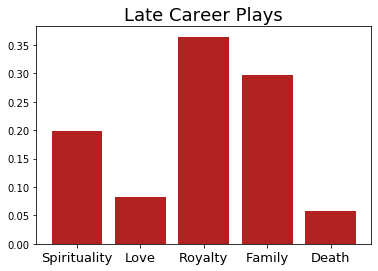

In [211]:
plt.bar(['Spirituality', 'Love', 'Royalty', 'Family', 'Death'], later_topic_normalized, color='firebrick')
plt.title("Late Career Plays", fontsize=18)
plt.xticks(fontsize=13)

In [160]:
H.iloc[s].describe()

,component_1,component_2,component_3,component_4,component_5
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.274376,1.449045,0.380539,0.306470,1.736392
std,0.380564,2.135425,0.896820,0.379435,1.831458
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.165550,0.196310,0.000000,0.149400,1.322080
75%,0.349370,2.209290,0.314970,0.516550,2.558260
max,1.374300,6.709170,3.528190,1.347920,6.096840


In [133]:
H

,component_1,component_2,component_3,component_4,component_5
0,0.00000,5.95888,0.00000,0.00000,0.17082
1,0.00000,6.18521,0.00000,0.11878,0.00000
2,0.24293,6.70917,0.00000,0.00000,0.02927
3,0.34937,3.19105,0.02451,0.00000,0.00000
4,0.00000,2.51845,0.31497,0.00000,0.62684
5,2.22512,0.00000,0.25629,0.00000,3.22074
6,11.56169,0.00000,0.00000,0.00000,0.00000
7,0.00000,0.00000,8.93122,0.36045,0.00000
8,0.11032,0.03530,5.85767,0.00000,0.31011
9,0.17601,0.00000,5.81249,0.00000,0.23237


In [ ]:
roju_ind = [0, 1, 2, 3, 4]
hamlet_ind = [5,6]
king_lear_ind = [7, 8, 9, 10, 11]
merchantvenice_ind = [12, 13, 14, 15, 16]
midsummer_ind = [17, 18, 19, 20, 21]
tempest_ind = [22, 23, 24, 25, 26]
kinsmen_ind = [27, 28, 29, 30, 31]
macbeth_ind = [32, 33, 34, 35, 36]
asyoulikeit_ind = [37, 38, 39, 40, 41]

tragedy_names = [
    'Romeo & Juliet',
    'Hamlet', 
    'King Lear',
    'The Tempest',
    'Macbeth'
]

comedy_names = [
    'Merchant of Venice',
    'Midsummer Nights Dream',
    'Two Noble Kinsmen',
    'As You Like It'
]

In [234]:
tragedy_inds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 22, 23, 24, 25, 26, 32, 33, 34, 35, 36]
comedy_inds = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 27, 28, 29, 30, 31, 37, 38, 39, 40, 41]

In [235]:
tragedy_topic_bars = H.iloc[tragedy_inds].mean()
comedy_topic_bars = H.iloc[comedy_inds].mean()

In [236]:
tragedy_topic_normalized = []
for i in tragedy_topic_bars.values:
    tragedy_topic_normalized.append(i / np.sum(tragedy_topic_bars))
tragedy_topic_normalized

[0.21765099257245524,
 0.31449571878970245,
 0.3241862552485991,
 0.017961065524149607,
 0.12570596786509342]

In [237]:
comedy_topic_normalized = []
for i in comedy_topic_bars.values:
    comedy_topic_normalized.append(i / np.sum(comedy_topic_bars.values))
comedy_topic_normalized

[0.02811491969883616,
 0.13305738604009493,
 0.10001861041574926,
 0.34643937610734427,
 0.3923697077379753]

([0, 1, 2, 3, 4], <a list of 5 Text xticklabel objects>)

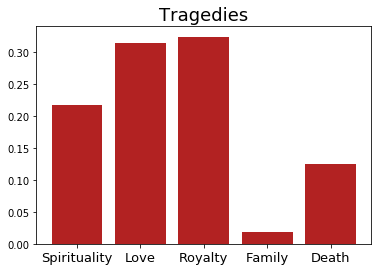

In [238]:
plt.bar(['Spirituality', 'Love', 'Royalty', 'Family', 'Death'], tragedy_topic_normalized, color='firebrick')
plt.title("Tragedies", fontsize=18)
plt.xticks(fontsize=13)

([0, 1, 2, 3, 4], <a list of 5 Text xticklabel objects>)

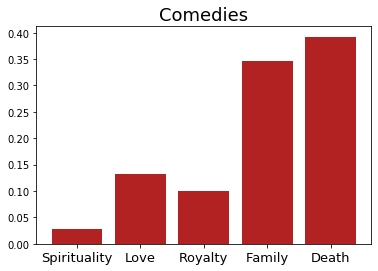

In [239]:
plt.bar(['Spirituality', 'Love', 'Royalty', 'Family', 'Death'], comedy_topic_normalized, color='firebrick')
plt.title("Comedies", fontsize=18)
plt.xticks(fontsize=13)

In [222]:
first_topic_inds = [0, 1, 2, 7, 8, 9, 12, 13, 14, 17, 18, 19, 22, 23, 24, 27, 28, 29, 32, 33, 34, 37, 38, 39]
last_topic_inds = [3, 4, 10, 11, 15, 16, 20, 21, 25, 26, 30, 31, 35, 36, 40, 41]

In [223]:
first_topic_bars = H.iloc[first_topic_inds].mean()
last_topic_bars = H.iloc[last_topic_inds].mean()

component_1    0.240934
component_2    0.876693
component_3    0.562326
component_4    0.908344
component_5    0.915052
dtype: float64

In [226]:
first_topic_normalized = []
for i in first_topic_bars.values:
    first_topic_normalized.append(i / np.sum(first_topic_bars))
first_topic_normalized

[0.05538645078969057,
 0.24973001904821873,
 0.2727361147335015,
 0.16187412007823515,
 0.26027329535035404]

In [227]:
last_topic_normalized = []
for i in last_topic_bars.values:
    last_topic_normalized.append(i / np.sum(last_topic_bars))
last_topic_normalized

[0.06877256768521557,
 0.25024423052221445,
 0.16051101088957714,
 0.25927879743673915,
 0.26119339346625375]

([0, 1, 2, 3, 4], <a list of 5 Text xticklabel objects>)

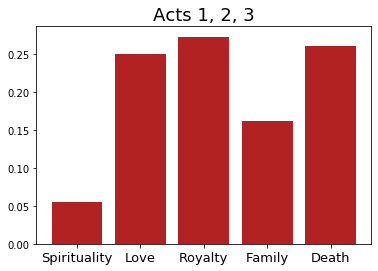

In [232]:
plt.bar(['Spirituality', 'Love', 'Royalty', 'Family', 'Death'], first_topic_normalized, color='firebrick')
plt.title("Acts 1, 2, 3", fontsize=18)
plt.xticks(fontsize=13)

([0, 1, 2, 3, 4], <a list of 5 Text xticklabel objects>)

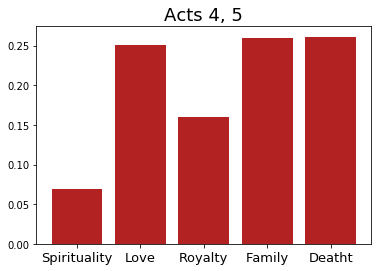

In [233]:
plt.bar(['Spirituality', 'Love', 'Royalty', 'Family', 'Deatht'], last_topic_normalized, color='firebrick')
plt.title("Acts 4, 5", fontsize=18)
plt.xticks(fontsize=13)

In [127]:
fake_df = pd.DataFrame([{'c1':10, 'c2':100}, {'c1':11,'c2':110}, {'c1':12,'c2':120}])
fake_df

,c1,c2
0,10,100
1,11,110
2,12,120


# Early vs Late Career Topic Analysis

In [21]:
early_career_play_names = [
    'Romeo & Juliet',
    'Merchant of Venice',
    'Midsummer Nights Dream',
    'Macbeth',
    'As You Like It'
]

later_career_play_names = [
    'Hamlet', 
    'The Tempest', 
    'Two Noble Kinsmen',
    'King Lear'
]

In [22]:
early_career_texts = []
later_career_texts = []

In [23]:
for act in all_acts:
    if act['Title'] in early_career_play_names:
        early_career_texts.append(act['Text'])
    else:
        later_career_texts.append(act['Text'])

In [24]:
count_vectorizer_EARLY = CountVectorizer(stop_words=union_stop_words, token_pattern="\\b[a-z][a-z]+\\b", min_df=0.1, max_df=0.9, ngram_range=(1,2))
count_vectorizer_EARLY.fit(early_career_texts)
doc_word_EARLY = count_vectorizer_EARLY.transform(early_career_texts)

count_vectorizer_LATE = CountVectorizer(stop_words=union_stop_words, token_pattern="\\b[a-z][a-z]+\\b", min_df=0.1, max_df=0.9, ngram_range=(1,2))
count_vectorizer_LATE.fit(later_career_texts)
doc_word_LATE = count_vectorizer_LATE.transform(later_career_texts)

print(doc_word_EARLY.shape)
print(doc_word_LATE.shape)

/Users/joelporcaro/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['exeunt', 'prologue', 'serv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(25, 2587)
(17, 4392)


In [92]:
nmf_model_EARLY = NMF(5)
doc_topic_EARLY = nmf_model_EARLY.fit_transform(doc_word_EARLY)

nmf_model_LATE = NMF(5)
doc_topic_LATE = nmf_model_LATE.fit_transform(doc_word_LATE)

In [93]:
topic_word_EARLY = pd.DataFrame(nmf_model_EARLY.components_.round(2),
                                index = ["component_1", "component_2", 'component_3', 'component_4', 'component_5'],
                                columns = count_vectorizer_EARLY.get_feature_names())

topic_word_LATE = pd.DataFrame(nmf_model_LATE.components_.round(2),
                                index = ["component_1", "component_2", 'component_3', 'component_4', 'component_5'],
                                columns = count_vectorizer_LATE.get_feature_names())

In [94]:
topic_word_EARLY

,abate,abed,abide,able,aboue,abroad,absence,absent,absolute,abusd,...,yond,yong,youl,youle,youll,youmacb,young,younger,youth,youthful
component_1,0.05,0.13,0.00,0.03,0.00,0.19,0.00,0.00,0.00,0.05,...,0.24,0.00,0.00,0.00,0.00,0.00,0.24,0.00,0.13,0.13
component_2,0.01,0.00,0.08,0.07,0.15,0.10,0.09,0.03,0.00,0.00,...,0.11,0.91,0.09,0.08,0.00,0.00,0.14,0.01,0.26,0.01
component_3,0.00,0.03,0.00,0.03,0.00,0.00,0.03,0.08,0.00,0.05,...,0.02,0.00,0.00,0.00,0.25,0.00,1.06,0.15,1.01,0.07
component_4,0.05,0.00,0.24,0.03,0.01,0.04,0.11,0.03,0.08,0.03,...,0.00,0.17,0.04,0.02,0.00,0.11,0.07,0.00,0.21,0.00
component_5,0.00,0.00,0.00,0.04,0.00,0.04,0.00,0.00,0.00,0.00,...,0.03,0.00,0.00,0.00,0.15,0.00,0.82,0.10,0.14,0.03


In [95]:
topic_word_LATE

,abatement,abhorred,abide,abjure,able,aboard,aboord,aboue,abroad,abroade,...,youl finde,youl loose,youll,young,younger,youngest,youshall,youth,youthe,youto
component_1,0.00,0.00,0.00,0.00,0.00,0.00,0.11,0.23,0.02,0.00,...,0.00,0.00,0.00,0.38,0.00,0.00,0.07,0.74,0.00,0.07
component_2,0.10,0.10,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.00,...,0.00,0.00,0.01,0.70,0.10,0.20,0.10,0.10,0.00,0.00
component_3,0.00,0.07,0.08,0.01,0.00,0.13,0.00,0.00,0.03,0.00,...,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.07,0.00
component_4,0.01,0.00,0.00,0.00,0.09,0.04,0.00,0.00,0.08,0.08,...,0.12,0.09,0.00,0.15,0.00,0.00,0.00,0.20,0.05,0.04
component_5,0.00,0.00,0.00,0.04,0.04,0.00,0.00,0.00,0.04,0.00,...,0.00,0.00,0.14,0.04,0.03,0.02,0.00,0.01,0.04,0.00


In [96]:
display_topics(nmf_model_EARLY, count_vectorizer_EARLY.get_feature_names(), 15)


Topic  0
friar, ill, lady, love, dead, night, prince, gone, look, heaven, father, slain, speak, mer, mother

Topic  1
iew, goe, faire, selfe, choose, father, iessica, neuer, bond, old, portia, lorenzo, fortune, christian, daughter

Topic  2
love, touchstone, duke, ill, father, corin, brother, fool, world, old, frederick, young, better, speak, forest

Topic  3
night, neuer, speake, looke, lysander, hermia, king, macbeth, moone, piramus, feare, faire, selfe, great, sleepe

Topic  4
love, ben, mer, night, fair, ill, wife, sweet, old, lady, young, god, light, capulet, wilt


In [97]:
display_topics(nmf_model_LATE, count_vectorizer_LATE.get_feature_names(), 15)


Topic  0
king, selfe, lordham, play, queene, mother, father, speake, heauen, thinke, laertes, looke, horatio, soule, owne

Topic  1
fool, love, father, speak, daughter, france, king, ill, exit, nature, cordelia, nuncle, cor, goneril, son

Topic  2
pope, conj, hanmer, om, sea, monster, dryden, king, collier, speak, island, om pope, spirit, note, master

Topic  3
daughter, love, iailor, wooer, cosen, friend, faire, doctor, goe, em, thinke, againe, oth, woman, gods

Topic  4
ill, corn, king, fool, poor, father, alb, night, osw, madam, exit, regan, edgar, speak, exeunt


In [102]:
H = pd.DataFrame(doc_topic_EARLY.round(5),
             index = ex_label,
             columns = ["component_1", "component_2", 'component_3', 'component_4', 'component_5'])
H

# take each number in each row and divide by sum of row for standarizing

NameError: name 'ex_label' is not defined

In [101]:
doc_topic_EARLY_LATE = doc_topic_EARLY

H = pd.DataFrame(doc_topic_LATE.round(5),
#              index = ex_label,
             columns = ["component_1", "component_2", 'component_3', 'component_4', 'component_5'])
H

,component_1,component_2,component_3,component_4,component_5
0,3.77471,0.06970,0.08671,0.45318,0.00000
1,13.02554,0.00000,0.00000,0.00000,0.00000
2,0.00000,10.17714,0.00000,0.00000,0.00000
3,0.00000,1.16866,0.00000,0.00000,7.05904
4,0.00000,0.80503,0.00000,0.00000,7.59910
5,0.00000,0.00000,0.27506,0.42627,7.96092
6,0.03999,0.00000,0.00000,0.46389,4.62745
7,0.00000,0.00000,8.59508,0.00000,0.00000
8,0.00000,0.00000,6.00233,0.06264,0.14887
9,0.02177,0.08996,3.41399,0.14613,0.19954


In [113]:
o = np.array([1, 2, 3])
p = np.array([4, 5, 6])

AttributeError: 'numpy.ndarray' object has no attribute 'append'

# Topic Variation by Genre

In [31]:
tragedy_names = [
    'Romeo & Juliet',
    'Hamlet', 
    'King Lear',
    'The Tempest',
    'Macbeth'
]

comedy_names = [
    'Merchant of Venice',
    'Midsummer Nights Dream',
    'Two Noble Kinsmen',
    'As You Like It'
]

In [32]:
tragedy_texts = []
comedy_texts = []

In [33]:
for act in all_acts:
    if act['Title'] in tragedy_names:
        tragedy_texts.append(act['Text'])
    else:
        comedy_texts.append(act['Text'])

In [34]:
count_vectorizer_TRAGEDY = CountVectorizer(stop_words=union_stop_words, token_pattern="\\b[a-z][a-z]+\\b", min_df=0.1, max_df=0.9, ngram_range=(1,2))
count_vectorizer_TRAGEDY.fit(tragedy_texts)
doc_word_TRAGEDY = count_vectorizer_TRAGEDY.transform(tragedy_texts)

count_vectorizer_COMEDY = CountVectorizer(stop_words=union_stop_words, token_pattern="\\b[a-z][a-z]+\\b", min_df=0.1, max_df=0.9, ngram_range=(1,2))
count_vectorizer_COMEDY.fit(comedy_texts)
doc_word_COMEDY = count_vectorizer_COMEDY.transform(comedy_texts)

print(doc_word_TRAGEDY.shape)
print(doc_word_COMEDY.shape)

/Users/joelporcaro/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['exeunt', 'prologue', 'serv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(22, 2784)
(20, 3891)


In [67]:
nmf_model_TRAGEDY = NMF(5)
doc_topic_TRAGEDY = nmf_model_TRAGEDY.fit_transform(doc_word_TRAGEDY)

nmf_model_COMEDY = NMF(5)
doc_topic_COMEDY = nmf_model_COMEDY.fit_transform(doc_word_COMEDY)

In [68]:
topic_word_TRAGEDY = pd.DataFrame(nmf_model_TRAGEDY.components_.round(2),
                                index = ["component_1", "component_2", 'component_3', 'component_4', 'component_5'],
                                columns = count_vectorizer_TRAGEDY.get_feature_names())

topic_word_COMEDY = pd.DataFrame(nmf_model_COMEDY.components_.round(2),
                                index = ["component_1", "component_2", 'component_3', 'component_4', 'component_5'],
                                columns = count_vectorizer_COMEDY.get_feature_names())

In [69]:
topic_word_TRAGEDY

,abhorred,abide,able,aboue,abroad,absolute,abusd,abuse,abuses,accent,...,yond,yong,youl,youll,youmacb,young,younger,youngest,youth,youthful
component_1,0.00,0.02,0.00,0.25,0.03,0.11,0.02,0.08,0.07,0.15,...,0.01,0.58,0.23,0.00,0.04,0.41,0.00,0.00,0.77,0.00
component_2,0.00,0.00,0.05,0.00,0.07,0.00,0.00,0.05,0.00,0.06,...,0.02,0.00,0.00,0.21,0.00,1.25,0.14,0.07,0.09,0.06
component_3,0.05,0.00,0.02,0.00,0.02,0.01,0.20,0.02,0.00,0.03,...,0.06,0.00,0.00,0.12,0.00,0.45,0.09,0.16,0.04,0.00
component_4,0.07,0.08,0.00,0.00,0.04,0.00,0.00,0.01,0.00,0.00,...,0.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
component_5,0.03,0.00,0.04,0.00,0.13,0.01,0.04,0.02,0.07,0.00,...,0.24,0.00,0.00,0.00,0.01,0.02,0.00,0.00,0.12,0.08


In [70]:
topic_word_COMEDY

,abate,abide,able,able discharge,aboue,abroad,abroade,absence,absent,abusd,...,young maid,young master,younger,younot,younot denie,youof,youpor,youth,youthful,zeale
component_1,0.02,0.10,0.08,0.05,0.18,0.13,0.00,0.12,0.05,0.00,...,0.00,0.00,0.00,0.12,0.12,0.00,0.19,0.33,0.02,0.02
component_2,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.02,0.10,0.07,...,0.09,0.09,0.06,0.00,0.00,0.00,0.00,1.07,0.05,0.00
component_3,0.00,0.00,0.08,0.00,0.00,0.07,0.07,0.00,0.01,0.00,...,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.12,0.00,0.01
component_4,0.07,0.25,0.04,0.02,0.00,0.01,0.00,0.07,0.02,0.03,...,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.24,0.01,0.02
component_5,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.02,0.01,0.00,...,0.01,0.01,0.19,0.00,0.00,0.00,0.00,0.35,0.06,0.00


In [71]:
display_topics(nmf_model_TRAGEDY, count_vectorizer_TRAGEDY.get_feature_names(), 15)


Topic  0
king, selfe, play, queene, speake, father, mother, heauen, thinke, looke, owne, soule, heare, dead, leaue

Topic  1
love, ben, mer, fair, ill, lady, young, god, serv, light, wilt, capulet, house, exeunt, peace

Topic  2
fool, father, king, ill, corn, love, speak, poor, nature, france, osw, daughter, alb, cor, goneril

Topic  3
pope, conj, hanmer, om, sea, monster, king, collier, island, speak, master, om pope, note, spirit, johnson

Topic  4
friar, ill, lady, dead, love, look, prince, heaven, father, madam, die, slain, speak, blood, tears


In [72]:
display_topics(nmf_model_COMEDY, count_vectorizer_COMEDY.get_feature_names(), 15)


Topic  0
iew, goe, faire, selfe, choose, iessica, neuer, bond, portia, father, lorenzo, old, maister, christian, exeunt

Topic  1
love, touchstone, ill, corin, duke, shepherd, forest, youth, think, senior, duke senior, woman, truly, look, fool

Topic  2
daughter, love, iailor, wooer, friend, cosen, doctor, faire, em, goe, noble, thinke, againe, oth, great

Topic  3
lysander, night, hermia, moone, neuer, piramus, wall, faire, looke, speake, play, helena, sweet, light, louers

Topic  4
father, duke, frederick, charles, le, young, old, brother, love, speak, adam, ill, better, fool, daughter


In [41]:
wordcloud = WordCloud().generate(s)

NameError: name 's' is not defined

# What's the thematic progression of a Shakespeare play?

In [42]:
first_acts_names = [
    all_acts[0], # Rome & Juliet
    all_acts[1],
    all_acts[2],
    all_acts[7], # King Lear
    all_acts[8],
    all_acts[9],
    all_acts[12], # Merchant of Venice
    all_acts[13],
    all_acts[14], 
    all_acts[17], # Midsummer Night's Dream
    all_acts[18],
    all_acts[19], 
    all_acts[22], # The Tempest
    all_acts[23],
    all_acts[24],
    all_acts[27], # Two Noble Kinsmen
    all_acts[28],
    all_acts[29],
    all_acts[32], # Macbeth
    all_acts[33],
    all_acts[34],
    all_acts[37], # As You Like It
    all_acts[38],
    all_acts[39]
]

last_acts_names = [
    all_acts[3], # Romeo & Juliet
    all_acts[4],
    all_acts[10], # King Lear
    all_acts[11],
    all_acts[15], # Merchant of Venice
    all_acts[16],
    all_acts[20], # Midsummer Night's Dream
    all_acts[21],
    all_acts[25], # The Tempest
    all_acts[26],
    all_acts[30], # Two Noble Kinsmen
    all_acts[31],
    all_acts[35], # Macbeth
    all_acts[36],
    all_acts[40], # As You Like It
    all_acts[41]
]

In [43]:
first_acts_text = []
last_acts_text = []

In [44]:
for act in first_acts_names:
    first_acts_text.append(act['Text'])
    
for act in last_acts_names:
    last_acts_text.append(act['Text'])

In [45]:
count_vectorizer_FIRST = CountVectorizer(stop_words=union_stop_words, token_pattern="\\b[a-z][a-z]+\\b", min_df=0.1, max_df=0.9, ngram_range=(1,2))
count_vectorizer_FIRST.fit(first_acts_text)
doc_word_FIRST = count_vectorizer_FIRST.transform(first_acts_text)

count_vectorizer_LAST = CountVectorizer(stop_words=union_stop_words, token_pattern="\\b[a-z][a-z]+\\b", min_df=0.1, max_df=0.9, ngram_range=(1,2))
count_vectorizer_LAST.fit(last_acts_text)
doc_word_LAST = count_vectorizer_LAST.transform(last_acts_text)

print(doc_word_FIRST.shape)
print(doc_word_LAST.shape)

/Users/joelporcaro/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['exeunt', 'prologue', 'serv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(24, 2751)
(16, 2730)


In [61]:
nmf_model_FIRST = NMF(5)
doc_topic_FIRST = nmf_model_FIRST.fit_transform(doc_word_FIRST)

nmf_model_LAST = NMF(5)
doc_topic_LAST = nmf_model_LAST.fit_transform(doc_word_LAST)

In [62]:
topic_word_FIRST = pd.DataFrame(nmf_model_FIRST.components_.round(2),
                                index = ["component_1", "component_2", 'component_3', 'component_4', 'component_5'],
                                columns = count_vectorizer_FIRST.get_feature_names())

topic_word_LAST = pd.DataFrame(nmf_model_LAST.components_.round(2),
                                index = ["component_1", "component_2", 'component_3', 'component_4', 'component_5'],
                                columns = count_vectorizer_LAST.get_feature_names())
# , 'component_6', 'component_7', 'component_8'

In [63]:
topic_word_FIRST

,abide,able,aboard,abroad,absence,absent,absolute,abusd,accent,according,...,yong,yong men,youle,youll,young,young master,younger,youngest,youth,youthful
component_1,0.00,0.05,0.06,0.17,0.00,0.00,0.00,0.00,0.06,0.05,...,0.00,0.00,0.00,0.17,1.13,0.00,0.10,0.03,0.07,0.11
component_2,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.17,0.03,0.06,...,0.00,0.00,0.00,0.11,0.55,0.03,0.10,0.18,0.00,0.01
component_3,0.19,0.04,0.02,0.11,0.13,0.00,0.07,0.01,0.00,0.12,...,0.74,0.09,0.07,0.00,0.00,0.00,0.00,0.00,0.22,0.00
component_4,0.07,0.00,0.14,0.03,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
component_5,0.00,0.04,0.01,0.00,0.01,0.09,0.01,0.04,0.05,0.00,...,0.00,0.02,0.00,0.07,1.05,0.08,0.16,0.15,0.94,0.06


In [64]:
topic_word_LAST

,abate,abhorred,abide,able,able discharge,abroad,absent,absolute,abusd,abuse,...,yew,yond,yong,youl,youl finde,youll,young,youth,youthe,youthful
component_1,0.11,0.09,0.00,0.09,0.00,0.10,0.00,0.00,0.10,0.00,...,0.19,0.18,0.00,0.00,0.00,0.06,0.09,0.35,0.00,0.11
component_2,0.00,0.00,0.00,0.07,0.00,0.07,0.00,0.00,0.00,0.07,...,0.00,0.00,0.68,0.32,0.13,0.00,0.06,0.10,0.07,0.00
component_3,0.04,0.04,0.14,0.11,0.09,0.07,0.12,0.06,0.00,0.00,...,0.06,0.00,0.44,0.19,0.00,0.00,0.25,0.20,0.00,0.04
component_4,0.00,0.00,0.01,0.07,0.00,0.01,0.00,0.06,0.08,0.09,...,0.00,0.31,0.00,0.00,0.00,0.02,0.05,0.03,0.08,0.00
component_5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.42,0.22,0.59,0.00,0.00


In [65]:
display_topics(nmf_model_FIRST, count_vectorizer_FIRST.get_feature_names(), 15)


Topic  0
love, ben, mer, night, ill, lady, fair, wife, wilt, sweet, god, word, light, speak, gone

Topic  1
fool, father, ill, corn, king, speak, love, poor, nature, night, daughter, france, regan, duke, osw

Topic  2
goe, faire, looke, selfe, speake, neuer, night, thinke, againe, lady, exeunt, daughter, owne, cosen, heare

Topic  3
pope, conj, hanmer, sea, om, king, monster, speak, island, collier, johnson, om pope, master, collier ms, ms

Topic  4
love, touchstone, duke, ill, corin, world, father, frederick, young, better, youth, brother, forest, little, think


In [66]:
display_topics(nmf_model_LAST, count_vectorizer_LAST.get_feature_names(), 15)


Topic  0
friar, dead, ill, night, par, love, watch, lady, mus, mother, help, prince, look, wife, county

Topic  1
daughter, iailor, wooer, doctor, friend, love, goe, faire, thinke, em, brother, gods, exeunt, messenger, knight

Topic  2
iew, wife, ring, selfe, night, feare, neuer, heare, moone, macbeth, poore, speake, doctor, leaue, flesh

Topic  3
alb, ill, madam, father, cor, king, old, exit, poor, edgar, look, dead, speak, hear, cordelia

Topic  4
love, duke, woman, morrow, brother, god, heart, marry, lie, ill, faith, hey, forest, word, shepherd


# Sentiment Analysis

### Across act progression

In [73]:
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

In [74]:
first_acts_polarities = []
for act in first_acts_names:
    first_acts_polarities.append(pol(act['Text']))

In [78]:
np.mean(first_acts_polarities)

0.1599899840023092

In [76]:
last_acts_polarities = []
for act in last_acts_names:
    last_acts_polarities.append(pol(act['Text']))

In [79]:
np.mean(last_acts_polarities)

0.1701331982617511

### Sentiment analysis across genre

In [82]:
tragedy_polarities = []
comedy_polarities = []

for act in all_acts:
    if act['Title'] in tragedy_names:
        tragedy_polarities.append(pol(act['Text']))
    else:
        comedy_polarities.append(pol(act['Text']))

In [85]:
print(np.mean(tragedy_polarities))
print(np.mean(comedy_polarities))

0.13464923182167496
0.19770653292101398


### sentiment analysis by career progression

In [87]:
early_polarities = []
later_polarities = []

for act in all_acts:
    if act['Title'] in early_career_play_names:
        early_polarities.append(pol(act['Text']))
    else:
        later_polarities.append(pol(act['Text']))

In [90]:
np.mean(early_polarities)

0.16425231974816076

In [91]:
np.mean(later_polarities)

0.16530033910547703

In [242]:
first_polarities = []
last_polarities = []

for act in first_acts_names:
    first_polarities.append(pol(act['Text']))

for act in last_acts_names:
    last_polarities.append(pol(act['Text']))

In [244]:
np.mean(first_polarities)

0.1599899840023092

In [245]:
np.mean(last_polarities)

0.1701331982617511

In [96]:
for i, act in enumerate(all_acts):
    print(str(i) + "  " + act['Title'] + "       " + " Act: " + act['Act'])

0  Romeo & Juliet        Act: 1
1  Romeo & Juliet        Act: 2
2  Romeo & Juliet        Act: 3
3  Romeo & Juliet        Act: 4
4  Romeo & Juliet        Act: 5
5  Hamlet        Act: 1
6  Hamlet        Act: 2
7  King Lear        Act: 1
8  King Lear        Act: 2
9  King Lear        Act: 3
10  King Lear        Act: 4
11  King Lear        Act: 5
12  Merchant of Venice        Act: 1
13  Merchant of Venice        Act: 2
14  Merchant of Venice        Act: 3
15  Merchant of Venice        Act: 4
16  Merchant of Venice        Act: 5
17  Midsummer Nights Dream        Act: 1
18  Midsummer Nights Dream        Act: 2
19  Midsummer Nights Dream        Act: 3
20  Midsummer Nights Dream        Act: 4
21  Midsummer Nights Dream        Act: 5
22  The Tempest        Act: 1
23  The Tempest        Act: 2
24  The Tempest        Act: 3
25  The Tempest        Act: 4
26  The Tempest        Act: 5
27  Two Noble Kinsmen        Act: 1
28  Two Noble Kinsmen        Act: 2
29  Two Noble Kinsmen        Act: 3
30  Two

In [140]:
roju_ind = [0, 1, 2, 3, 4]
hamlet_ind = [5,6]
king_lear_ind = [7, 8, 9, 10, 11]
merchantvenice_ind = [12, 13, 14, 15, 16]
midsummer_ind = [17, 18, 19, 20, 21]
tempest_ind = [22, 23, 24, 25, 26]
kinsmen_ind = [27, 28, 29, 30, 31]
macbeth_ind = [32, 33, 34, 35, 36]
asyoulikeit_ind = [37, 38, 39, 40, 41]